In [144]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.optimize as spo
import pandas_datareader.data as web
import datetime as dt
import math as m
from dateutil.relativedelta import relativedelta
plt.style.use(['seaborn-dark'])

In [224]:
# Constants
NUMBER_TESTS = 2
PORTFOLIO_SIZE = 25
AUM = 1000000

# Holding period is expressed in years
HOLDING_PERIOD = 4

# Window and Adjust Frequency are expressed in days
WINDOW = 1
ADJUSTMENT_FREQUENCY = 4

In [225]:
# Load all ticker symbols in S&P 500
sp500_tickers = []
with open('sp500_tickers.csv', 'r') as f:
    sp500_tickers = f.readlines()[0].split('\r')

# Load black list
# Used to filter out newly listed companies
black_list = []
with open('black_list.csv', 'r') as f:
    black_list = f.readlines()[0].split('\r')
    
# Update S&P 500 list
sp500_tickers = [i for i in sp500_tickers if i not in black_list]

number_tickers = len(sp500_tickers)

# Build tickers array with random tickers
tickers = []
for x in range(0, NUMBER_TESTS):
    indexes = np.random.randint(0, number_tickers, PORTFOLIO_SIZE)
    tickers.append([sp500_tickers[i] for i in indexes])

In [226]:
end_date = dt.datetime(2015, 1, 1)
start_date = end_date - relativedelta(years=HOLDING_PERIOD + 1)

def get_data(tickers, start_date, end_date):
    dates = pd.date_range(start_date, end_date)
    df = pd.DataFrame(index=dates)
    
    for ticker in tickers:
        df_temp = web.DataReader(ticker, 'yahoo', start_date, end_date)[['Adj Close']]
        df_temp = df_temp.rename(columns={'Adj Close': ticker})
        df = df.join(df_temp)

    df = df.dropna()    
    return df



In [227]:
def optimize_portfolio(prices, d0, d1):
    
    # Slice prices by date going back by window
    prices = prices.copy().ix[d0:d1]
    starting_value = AUM
    normalized_prices = prices / prices.ix[0, :]
    x0 = np.array([1. / PORTFOLIO_SIZE] * PORTFOLIO_SIZE)
    optimal_allocations = spo.minimize(f, x0,
                                       args=(normalized_prices, starting_value),
                                       method='SLSQP', options={'disp': False},
                                       bounds=tuple((0, 1) for i in range(0, x0.size)),
                                       constraints = ({'type': 'eq', 'fun': \
                                                       lambda inputs: 1.0 - np.sum(inputs)})
                                       )
    return optimal_allocations.x
    
def f(x, normalized_prices, starting_value):
    
    port_val, \
    cum_return, \
    avg_daily_return, \
    std_daily_return, \
    sharpe_ratio = \
        calc_portfolio_stats(x, normalized_prices, starting_value)
    
    # Return negative Sharpe Ratio b/c we are minimizing this function
    return sharpe_ratio * -1

def calc_portfolio_stats(allocs, normalized_prices, starting_value):
    # Calculate position values and sum for portfolio values
    position_values = (allocs * normalized_prices * starting_value).dropna()
    port_val = position_values.sum(axis=1)

    # Get portfolio statistics
    portfolio_returns = (port_val / port_val.shift(1) - 1).fillna(0)
    cum_returns = (portfolio_returns + 1).cumprod()[-1] - 1
    avg_daily_return = portfolio_returns.mean()
    std_daily_return = portfolio_returns.std()
    sharpe_ratio = ((avg_daily_return - 0) / std_daily_return) * m.sqrt(252)

    return port_val, cum_returns, avg_daily_return, std_daily_return, sharpe_ratio

In [228]:
results = []
for ticker_list in tickers:
    
    d0 = start_date
    prices = get_data(ticker_list, start_date, end_date)
    normalized_prices = prices / prices.ix[0, :]
    
    # Create Allocations Dataframe
    dates = pd.date_range(start_date, end_date)
    allocations = pd.DataFrame(columns=ticker_list)
    print ticker_list

    for x in range(0, HOLDING_PERIOD * (12 / ADJUSTMENT_FREQUENCY) + 1):
        # Optimize portfoio for past window
        d1 = d0 + relativedelta(years=WINDOW)
        allocs = optimize_portfolio(prices, d0, d1)

        date_range = pd.date_range(d0, d1)
        df = pd.DataFrame([allocs], columns=ticker_list, index=date_range)

        if x > 0:
            da = d1 - relativedelta(months=3)
            df = df[da:d1]
        
        # Update allocations df
        allocations = allocations.append(df)
        
        # Move window forward by x number of months
        d0 = d0 + relativedelta(months=ADJUSTMENT_FREQUENCY)
    
    optimized = calc_portfolio_stats(allocations, normalized_prices, AUM)
    standard = calc_portfolio_stats(np.array([1. / PORTFOLIO_SIZE] * PORTFOLIO_SIZE), normalized_prices, AUM)
    results.append((optimized, standard))

['NEM', 'IP', 'BDX', 'AMP', 'FSLR', 'STZ', 'CB', 'DG', 'BBBY', 'PEG', 'BCR', 'ES', 'LUK', 'BBY', 'UHS', 'NOC', 'TROW', 'WBA', 'UNH', 'IR', 'APA', 'JBHT', 'PNR', 'VRSN', 'NUE']
['BCR', 'CINF', 'GT', 'SO', 'AVY', 'O', 'MAS', 'AMG', 'MMM', 'WFM', 'DVN', 'PPG', 'DO', 'KR', 'PGR', 'AZO', 'BWA', 'GPC', 'CCL', 'GOOGL', 'V', 'FDX', 'FFIV', 'GILD', 'JNPR']


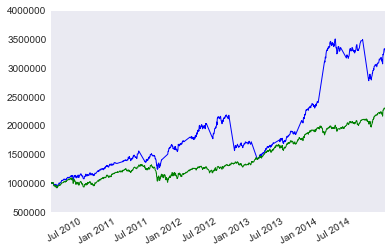

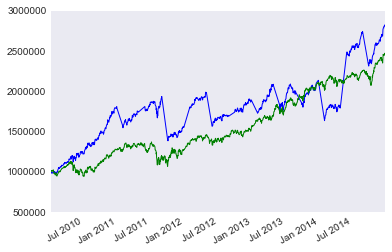

In [229]:
for result in results:
    result[0][0].plot()
    result[1][0].plot()
    plt.show()

In [221]:
for result in results:
    optimized_cum_return = result[0][1]
    standard_cum_return = result[1][1]
    print '%f %f -> %f' % (optimized_cum_return, standard_cum_return, 
                           optimized_cum_return - standard_cum_return)

1.751207 1.120354 -> 0.630852


In [222]:
for result in results:
    optimized_vol = result[0][3] * 100
    standard_vol = result[1][3] * 100
    print '%f %f' % (optimized_vol, standard_vol)

2.544183 1.086445


In [223]:
print results[2][0][1]
print results[2][0][0][0]
print results[2][0][0][-1]
print results[2][0][0][-1] / results[2][0][0][0] - 1
port_val =  results[2][0][0]
portfolio_returns = (port_val / port_val.shift(1) - 1).fillna(0)
portfolio_returns.cumsum().plot()
plt.show()
results[2][0][0].plot()
plt.show()

(portfolio_returns + 1).cumprod()

IndexError: list index out of range